## 🛠️ Data Augmentation Setup

In [1]:
# 📦 Essential libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, ResNet50, DenseNet121
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout


2025-04-26 03:21:19.474299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745637679.675110      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745637679.733938      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Replace with your actual path if different
base_path = "/kaggle/input/breast-histopathology-images"

# Gather all image paths
all_image_paths = glob(os.path.join(base_path, "*", "*", "*.png"))

print("Total images:", len(all_image_paths))


Total images: 277524


In [3]:
# Extract label from path (0 = no cancer, 1 = cancer)
data = pd.DataFrame({
    "path": all_image_paths,
    "label": [int("class1" in x) for x in all_image_paths]
})

# Count classes
print(data['label'].value_counts())

# Preview
data.head()


label
0    198738
1     78786
Name: count, dtype: int64


path  label
0  /kaggle/input/breast-histopathology-images/102...      0
1  /kaggle/input/breast-histopathology-images/102...      0
2  /kaggle/input/breast-histopathology-images/102...      0
3  /kaggle/input/breast-histopathology-images/102...      0
4  /kaggle/input/breast-histopathology-images/102...      0

## 📦 Import Required Libraries

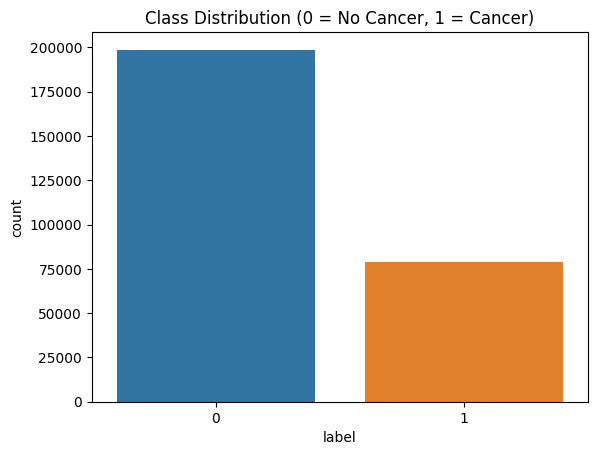

No Cancer: 198738 | Cancer: 78786


In [4]:
import seaborn as sns

sns.countplot(data=data, x='label')
plt.title('Class Distribution (0 = No Cancer, 1 = Cancer)')
plt.show()

# Print actual counts
neg, pos = data['label'].value_counts()
print(f"No Cancer: {neg} | Cancer: {pos}")


## 📦 Import Required Libraries

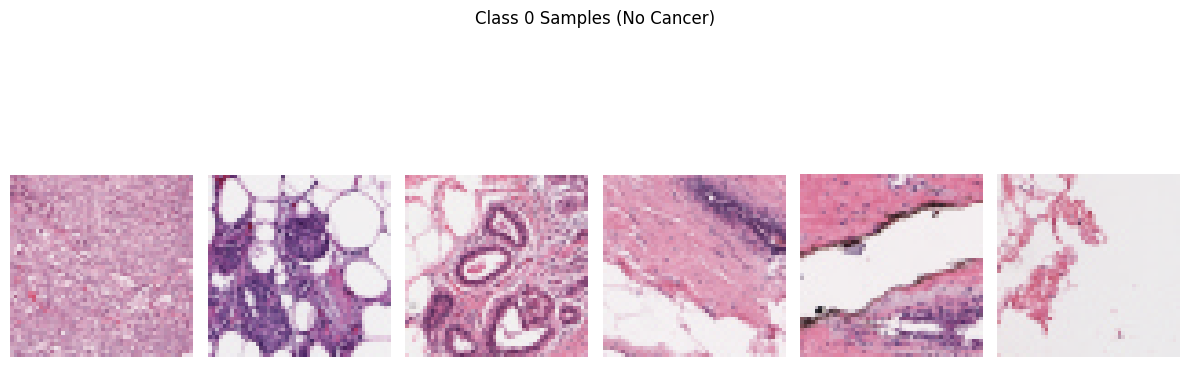

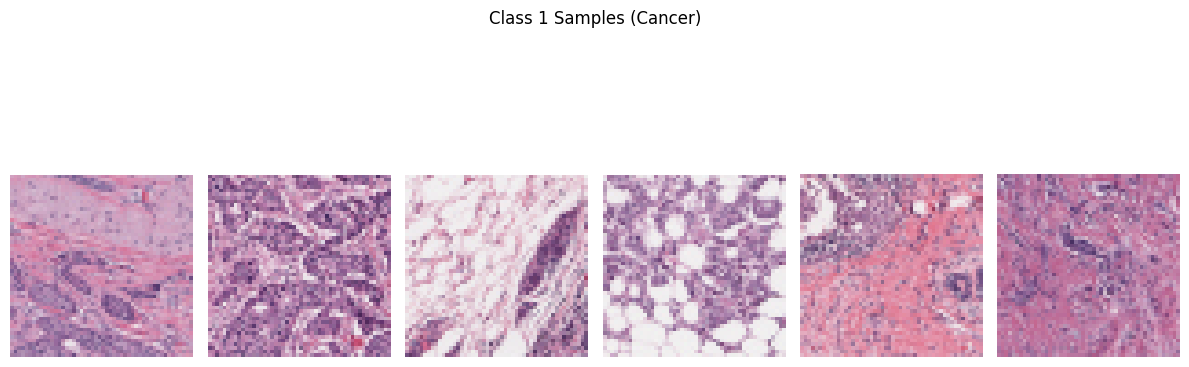

In [5]:
import cv2
import random

def show_samples(label, count=6):
    sample_paths = data[data['label'] == label].sample(count)['path'].tolist()
    plt.figure(figsize=(12, 5))
    for i, img_path in enumerate(sample_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, count, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f"Class {label} Samples ({'Cancer' if label==1 else 'No Cancer'})")
    plt.tight_layout()
    plt.show()

# Show 6 images from each class
show_samples(0)
show_samples(1)


In [6]:
img = cv2.imread(data['path'].iloc[0])
print("Sample image shape:", img.shape)


Sample image shape: (50, 50, 3)


In [7]:
# Sample 30,000 from each class
neg_samples = data[data['label'] == 0].sample(30000, random_state=42)
pos_samples = data[data['label'] == 1].sample(30000, random_state=42)

# Merge
balanced_data = pd.concat([neg_samples, pos_samples]).reset_index(drop=True)

# Label as string
balanced_data['label'] = balanced_data['label'].astype(str)

# Re-split
train_paths, test_paths = train_test_split(balanced_data, test_size=0.1, stratify=balanced_data['label'], random_state=42)
train_paths, val_paths = train_test_split(train_paths, test_size=0.1111, stratify=train_paths['label'], random_state=42)

print(f"Train: {len(train_paths)} | Val: {len(val_paths)} | Test: {len(test_paths)}")


Train: 48000 | Val: 6000 | Test: 6000


## 🛠️ Data Augmentation Setup

In [8]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Augmentation
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)
print("1")
val_aug = ImageDataGenerator(rescale=1./255)

# Train generator
train_gen = train_aug.flow_from_dataframe(
    train_paths,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
print("1")
# Val generator
val_gen = val_aug.flow_from_dataframe(
    val_paths,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
print("1")
# Test generator
test_gen = val_aug.flow_from_dataframe(
    test_paths,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


1
Found 48000 validated image filenames belonging to 2 classes.
1
Found 6000 validated image filenames belonging to 2 classes.
1
Found 6000 validated image filenames belonging to 2 classes.


In [29]:
# Calculate class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_paths['label']),
    y=train_paths['label']
)
class_weights = {i: w for i, w in enumerate(weights)}
print("Class weights:", class_weights)


Class weights: {0: 1.0, 1: 1.0}


## 📦 Import Required Libraries

In [30]:
from tensorflow.keras.models import Model


## 🏗️ Build CNN Models

In [31]:
# Inputs
input_tensor = Input(shape=(224, 224, 3))

# EfficientNetB0 Backbone
effnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in effnet_base.layers:
    layer.trainable = False
effnet_output = effnet_base(input_tensor)
effnet_output = GlobalAveragePooling2D()(effnet_output)

# ResNet50 Backbone
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in resnet_base.layers:
    layer.trainable = False
resnet_output = resnet_base(input_tensor)
resnet_output = GlobalAveragePooling2D()(resnet_output)

# DenseNet121 Backbone
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in densenet_base.layers:
    layer.trainable = False
densenet_output = densenet_base(input_tensor)
densenet_output = GlobalAveragePooling2D()(densenet_output)

# Concatenate
fusion = Concatenate()([effnet_output, resnet_output, densenet_output])

# Dense Layers
x = Dense(512, activation='relu')(fusion)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Output Layer
output = Dense(1, activation='sigmoid')(x)

# Model
model = Model(inputs=input_tensor, outputs=output)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 7, 7, 1280)     │      4,049,571 │ input_layer_4[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ densenet121 (Functional)  │ (None, 7, 7, 1024)     │      7,037,504 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1280)           │              0 │ efficientnetb0[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ densenet121[0][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 4352)           │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 512)            │      2,228,736 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 512)            │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 128)            │         65,664 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1)              │            129 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 36,969,316 (141.03 MB)

 Trainable params: 2,294,529 (8.75 MB)

 Non-trainable params: 34,674,787 (132.27 MB)

## 📦 Import Required Libraries

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [13]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/fusion_model_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)


## 🚂 Train the Fusion Model

In [14]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,  # Early stopping will trigger earlier if needed
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights,
    verbose=1
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745637904.911553      98 service.cc:148] XLA service 0x7a6e0c13e7a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745637904.912543      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745637904.912564      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745637910.399078      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745637934.383163      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.7495 - loss: 0.5100
Epoch 1: val_accuracy improved from -inf to 0.82183, saving model to /kaggle/working/fusion_model_best.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 889s 542ms/step - accuracy: 0.7496 - loss: 0.5099 - val_accuracy: 0.8218 - val_loss: 0.3964
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.8240 - loss: 0.4027
Epoch 2: val_accuracy improved from 0.82183 to 0.82900, saving model to /kaggle/working/fusion_model_best.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 543s 361ms/step - accuracy: 0.8240 - loss: 0.4027 - val_accuracy: 0.8290 - val_loss: 0.3865
Epoch 3/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.8313 - loss: 0.3884
Epoch 3: val_accuracy improved from 0.82900 to 0.83683, saving model to /kaggle/working/fusion_model_best.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 548s 364ms/step - accuracy: 0.8313 - loss: 0.3884 - val_accuracy: 0.8368 - val_loss: 0.3737
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━

## 📦 Import Required Libraries

188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 221ms/step - accuracy: 0.8572 - loss: 0.3380
Test Accuracy: 0.8555 | Test Loss: 0.3402
188/188 ━━━━━━━━━━━━━━━━━━━━ 78s 298ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      3000
           1       0.85      0.86      0.86      3000

    accuracy                           0.86      6000
   macro avg       0.86      0.86      0.86      6000
weighted avg       0.86      0.86      0.86      6000



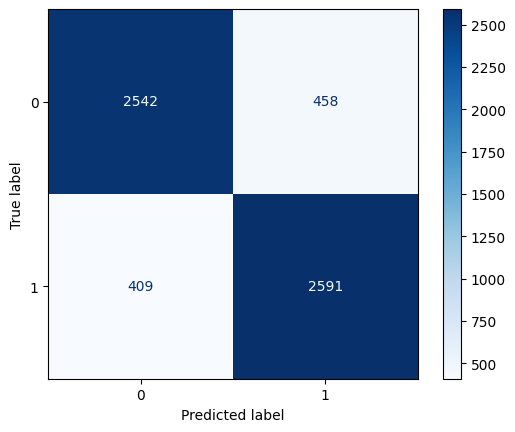

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

# Evaluate on test set
loss, accuracy = model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy: {accuracy:.4f} | Test Loss: {loss:.4f}")

# Predict on test set
y_pred_probs = model.predict(test_gen)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = test_gen.classes

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')


In [16]:
# Save final model (optional, if not using best checkpoint)
model.save('/kaggle/working/fusion_model_final.keras')

# Save predictions
pred_df = pd.DataFrame({
    'file': test_gen.filenames,
    'actual': y_true,
    'predicted': y_pred.flatten(),
    'probability': y_pred_probs.flatten()
})

pred_df.to_csv('/kaggle/working/fusion_predictions.csv', index=False)


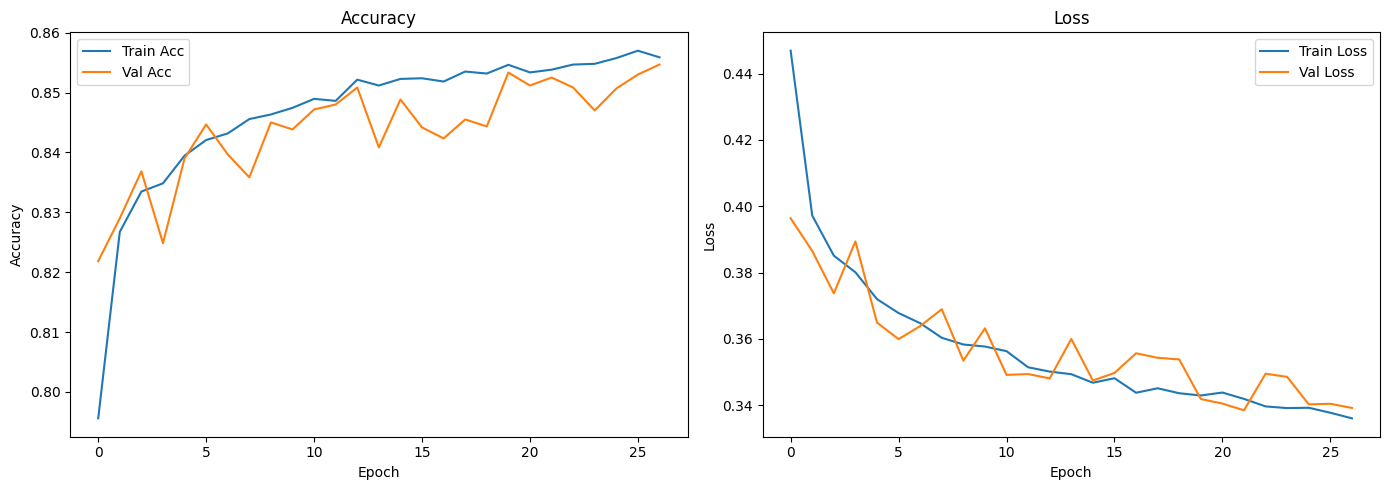

In [17]:
# Plot accuracy and loss
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## 📦 Import Required Libraries

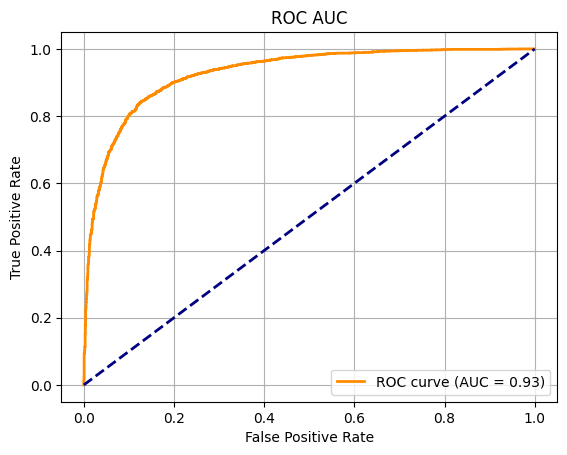

In [18]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC')
plt.legend(loc='lower right')
plt.grid()
plt.show()


## 📦 Import Required Libraries

In [19]:
import tensorflow.keras.backend as K
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


## 🔗 Combine Models (Fusion CNN)

In [20]:
# Build temp classifier model on top of resnet_base
resnet_input = resnet_base.input
resnet_output = resnet_base.output
gap = GlobalAveragePooling2D()(resnet_output)
dense_out = Dense(1, activation='sigmoid')(gap)

resnet_model_for_gradcam = Model(inputs=resnet_input, outputs=dense_out)


## 🔥 Grad-CAM Explainability

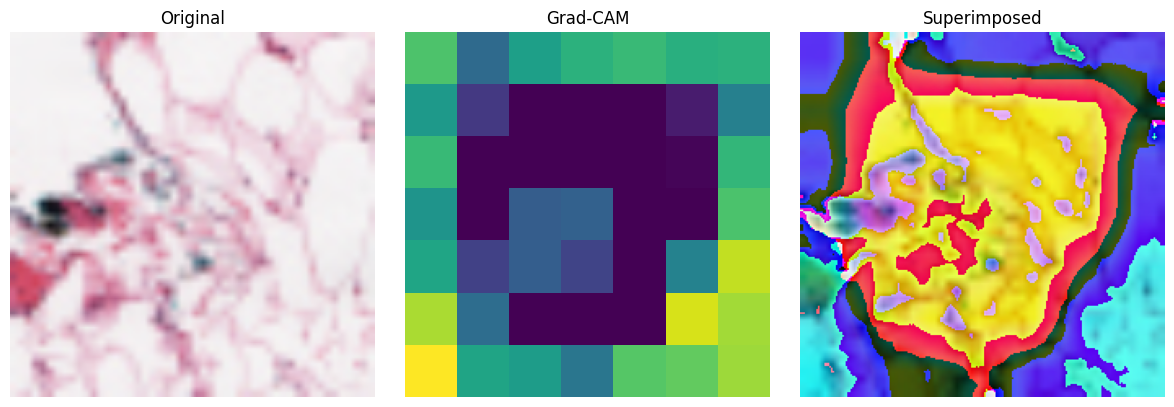

In [21]:
# Pick a random test image
test_img_path = test_paths.sample(1)['path'].values[0]

# Load and preprocess image
img = tf.keras.preprocessing.image.load_img(test_img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0


# Use ResNet only for Grad-CAM
heatmap = make_gradcam_heatmap(img_array, resnet_model_for_gradcam, 'conv5_block3_out')

# Superimpose heatmap
img_original = cv2.imread(test_img_path)
img_original = cv2.resize(img_original, (224, 224))
heatmap_resized = cv2.resize(heatmap, (img_original.shape[1], img_original.shape[0]))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
superimposed_img = heatmap_colored * 0.4 + img_original

# Display
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Grad-CAM")
plt.imshow(heatmap, cmap='viridis')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Superimposed")
plt.imshow(cv2.cvtColor(superimposed_img.astype('uint8'), cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


## 🔍 Explainability: Grad-CAM Visualization

To make our model explainable, we used Grad-CAM (Gradient-weighted Class Activation Mapping).  
Grad-CAM allows us to see **which parts of the image the model focused on** when making a prediction.

This is critical in healthcare, where model transparency and trustworthiness are essential.

We applied Grad-CAM to the final convolutional layer of ResNet50 inside our fusion model.


## 🏗️ Build CNN Models

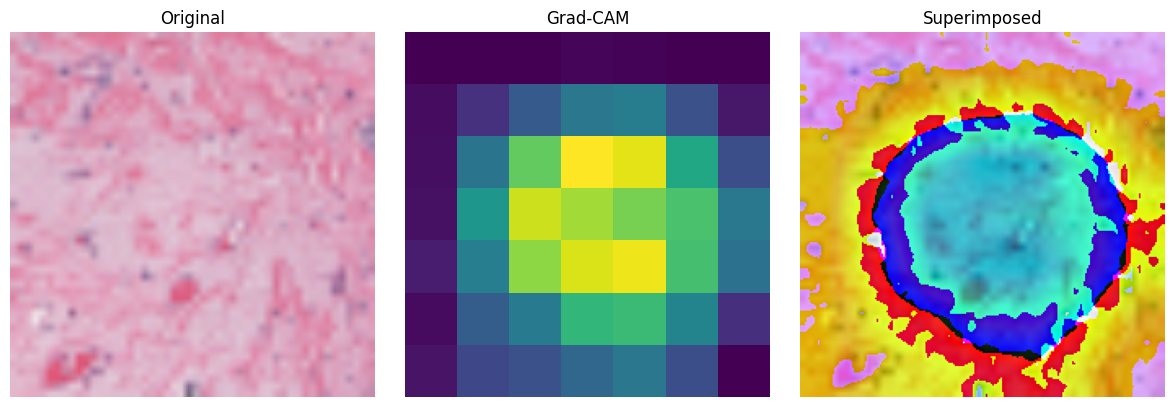

In [22]:
# 👇 TEMP model for Grad-CAM (ResNet50 + GAP + Dense)
resnet_input = resnet_base.input
resnet_output = resnet_base.output
gap = GlobalAveragePooling2D()(resnet_output)
dense_out = Dense(1, activation='sigmoid')(gap)
resnet_model_for_gradcam = Model(inputs=resnet_input, outputs=dense_out)

# 👇 Grad-CAM function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 👇 Choose random test image
test_img_path = test_paths.sample(1)['path'].values[0]
img = tf.keras.preprocessing.image.load_img(test_img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# 👇 Generate heatmap from ResNet's last conv block
heatmap = make_gradcam_heatmap(img_array, resnet_model_for_gradcam, 'conv5_block3_out')

# 👇 Overlay heatmap on original image
img_original = cv2.imread(test_img_path)
img_original = cv2.resize(img_original, (224, 224))
heatmap_resized = cv2.resize(heatmap, (img_original.shape[1], img_original.shape[0]))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
superimposed_img = heatmap_colored * 0.4 + img_original

# 👇 Display
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Grad-CAM")
plt.imshow(heatmap, cmap='viridis')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Superimposed")
plt.imshow(cv2.cvtColor(superimposed_img.astype('uint8'), cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


## 🔥 Grad-CAM Explainability

In [23]:
def visualize_multiple_gradcams(model, base_model, conv_layer_name, class_label, count=4):
    samples = test_paths[test_paths['label'] == str(class_label)].sample(count)['path'].values

    plt.figure(figsize=(15, 4 * count))

    for i, path in enumerate(samples):
        # Load and preprocess
        img = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array_exp = np.expand_dims(img_array, axis=0) / 255.0

        # Grad-CAM
        heatmap = make_gradcam_heatmap(img_array_exp, model, conv_layer_name)

        # Superimpose
        orig_img = cv2.imread(path)
        orig_img = cv2.resize(orig_img, (224, 224))
        heatmap_resized = cv2.resize(heatmap, (224, 224))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        superimposed_img = heatmap_colored * 0.4 + orig_img

        # Plot
        plt.subplot(count, 3, 3 * i + 1)
        plt.title(f"Original - Class {class_label}")
        plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(count, 3, 3 * i + 2)
        plt.title("Grad-CAM Heatmap")
        plt.imshow(heatmap, cmap='inferno')
        plt.axis('off')

        plt.subplot(count, 3, 3 * i + 3)
        plt.title("Superimposed")
        plt.imshow(cv2.cvtColor(superimposed_img.astype('uint8'), cv2.COLOR_BGR2RGB))
        plt.axis('off')

    plt.tight_layout()
    plt.show()


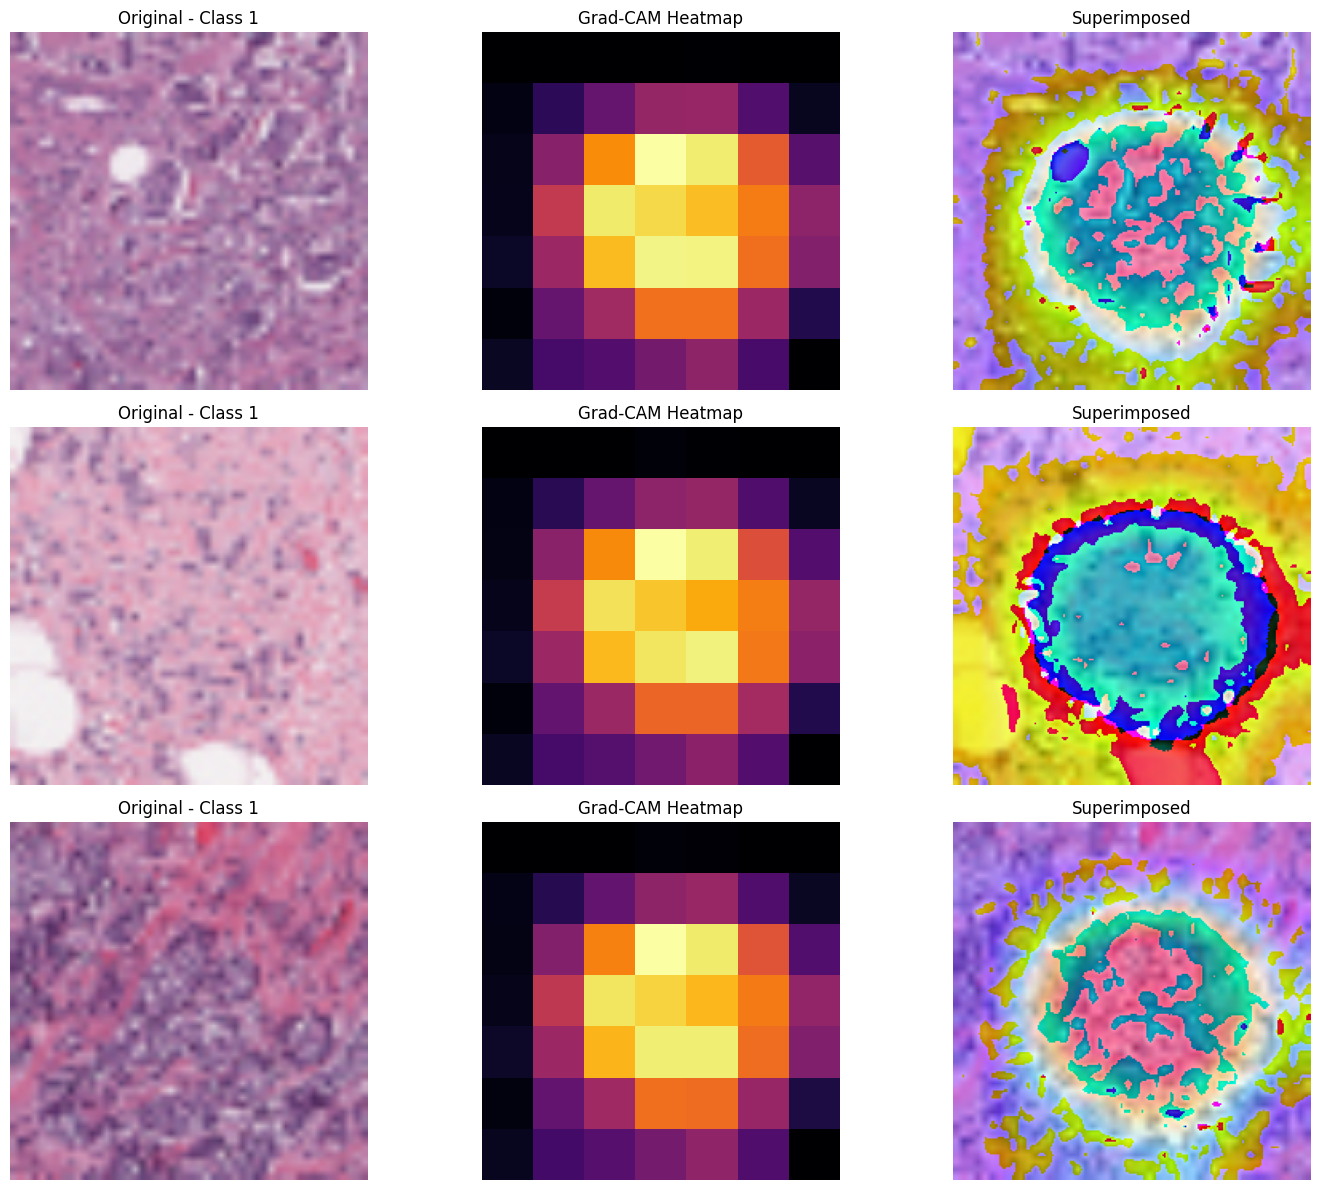

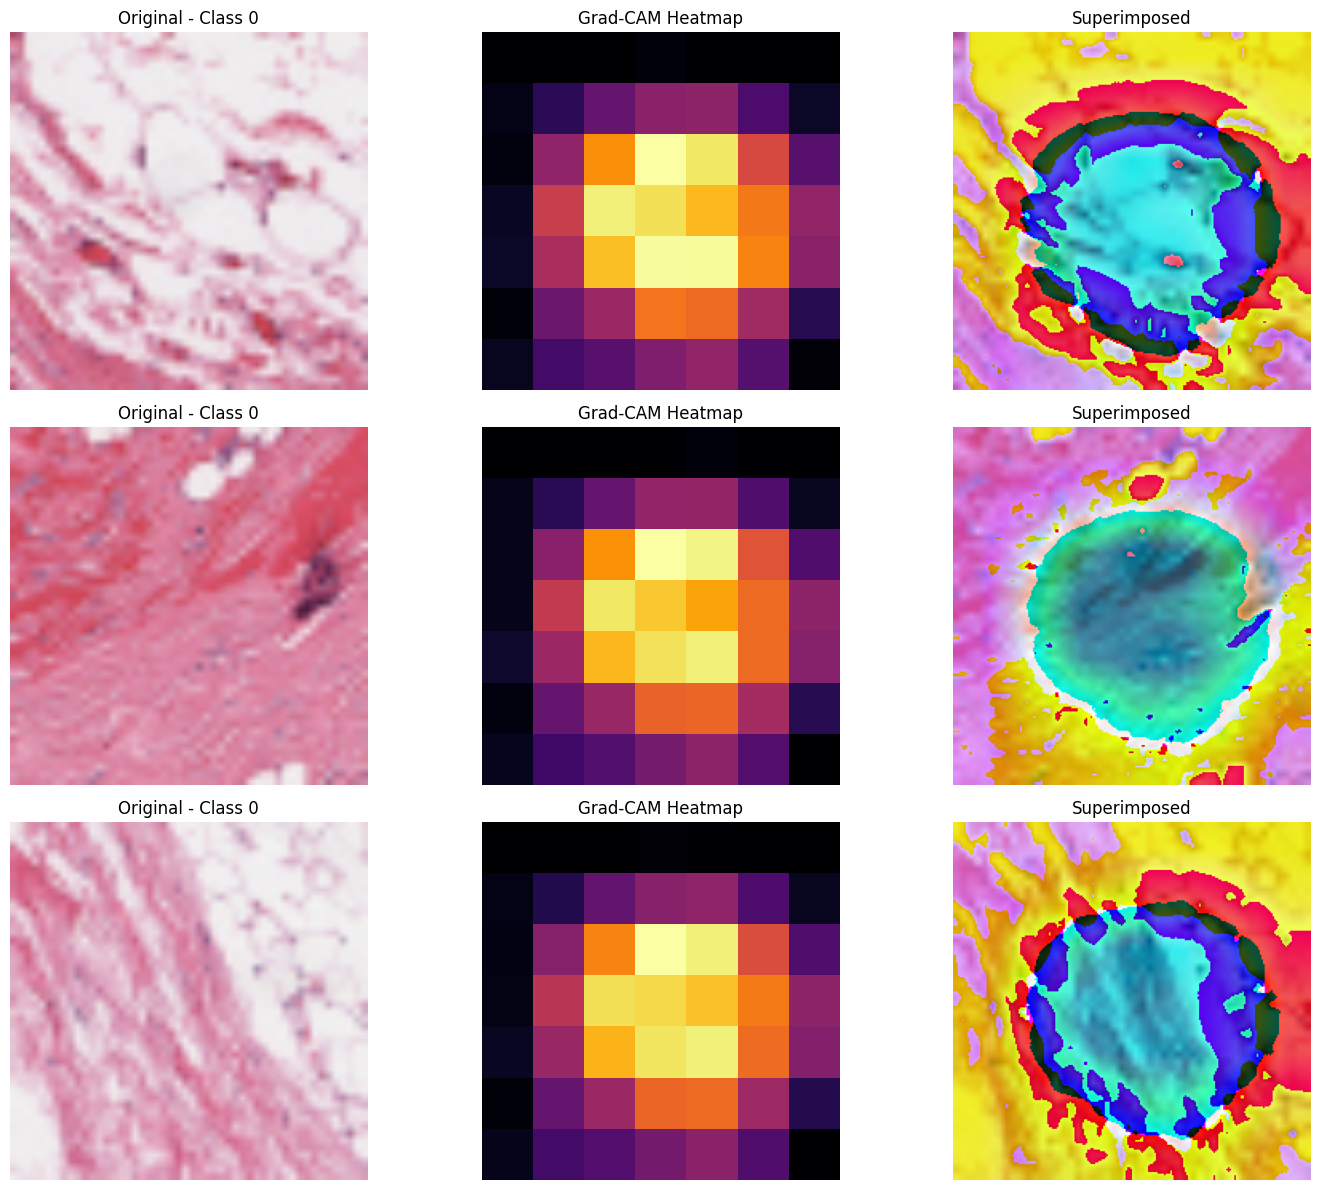

In [24]:
# Cancer (label=1)
visualize_multiple_gradcams(resnet_model_for_gradcam, resnet_base, 'conv5_block3_out', class_label=1, count=3)

# No cancer (label=0)
visualize_multiple_gradcams(resnet_model_for_gradcam, resnet_base, 'conv5_block3_out', class_label=0, count=3)


## 🧠 Saliency Map Visualization

In [25]:
def compute_saliency_map(img_array, model):
    img_tensor = tf.convert_to_tensor(img_array)

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        loss = preds[:, 0]  # for binary classification

    grads = tape.gradient(loss, img_tensor)[0]

    # Take maximum absolute gradient across color channels
    saliency = np.max(np.abs(grads), axis=-1)

    # Normalize between 0 and 1
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-10)

    return saliency


## 🧠 Saliency Map Visualization

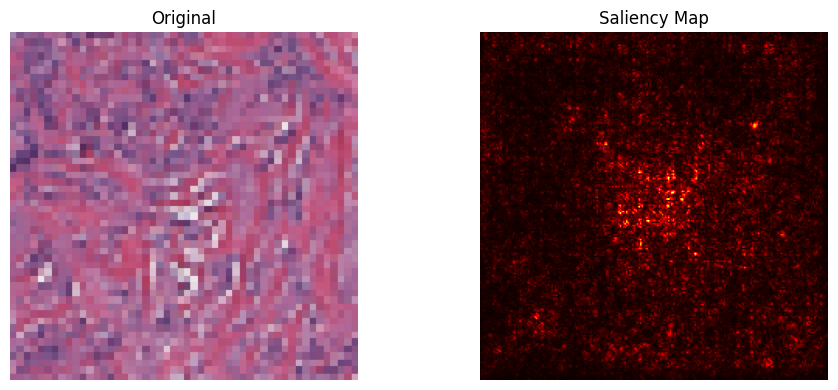

In [26]:
# Pick a test image
test_img_path = test_paths.sample(1)['path'].values[0]

# Load image
img = tf.keras.preprocessing.image.load_img(test_img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array_exp = np.expand_dims(img_array, axis=0) / 255.0

# Compute saliency
saliency_map = compute_saliency_map(img_array_exp, resnet_model_for_gradcam)

# Plot original + saliency
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(np.array(img).astype('uint8'))  # 🔧 Fixed here
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Saliency Map")
plt.imshow(saliency_map, cmap='hot')
plt.axis('off')

plt.tight_layout()
plt.show()


## 🧠 Saliency Map Visualization

In [27]:
def visualize_multiple_saliency_maps(model, class_label, count=4):
    """
    Visualize multiple saliency maps for a given class label (0 or 1).
    """
    samples = test_paths[test_paths['label'] == str(class_label)].sample(count)['path'].values

    plt.figure(figsize=(15, 4 * count))

    for i, path in enumerate(samples):
        # Load and preprocess
        img = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array_exp = np.expand_dims(img_array, axis=0) / 255.0

        # Compute saliency
        saliency_map = compute_saliency_map(img_array_exp, resnet_model_for_gradcam)

        # Plot
        plt.subplot(count, 2, 2 * i + 1)
        plt.title(f"Original - Class {class_label}")
        plt.imshow(np.array(img).astype('uint8'))
        plt.axis('off')

        plt.subplot(count, 2, 2 * i + 2)
        plt.title("Saliency Map")
        plt.imshow(saliency_map, cmap='hot')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


## 🧠 Saliency Map Visualization

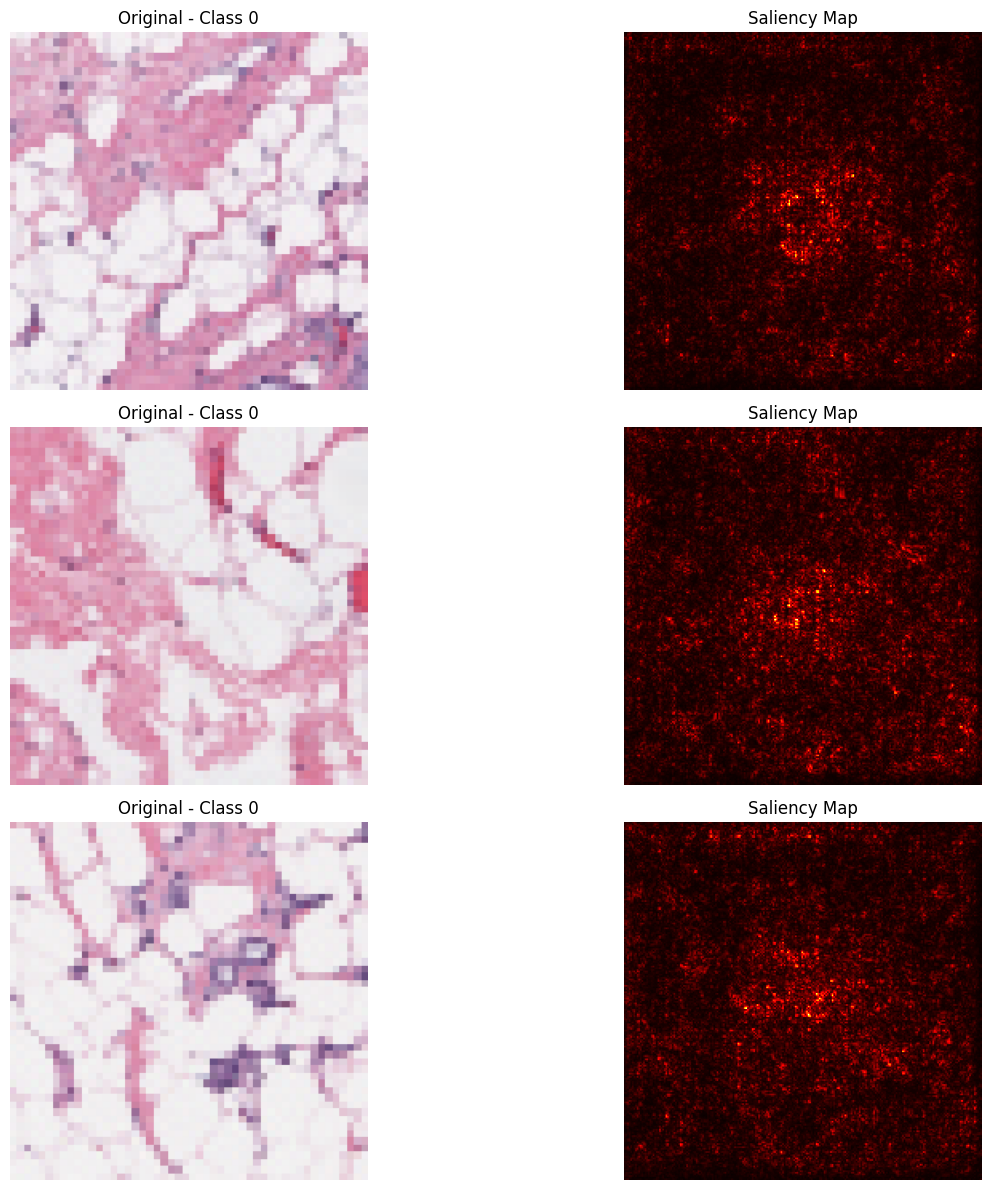

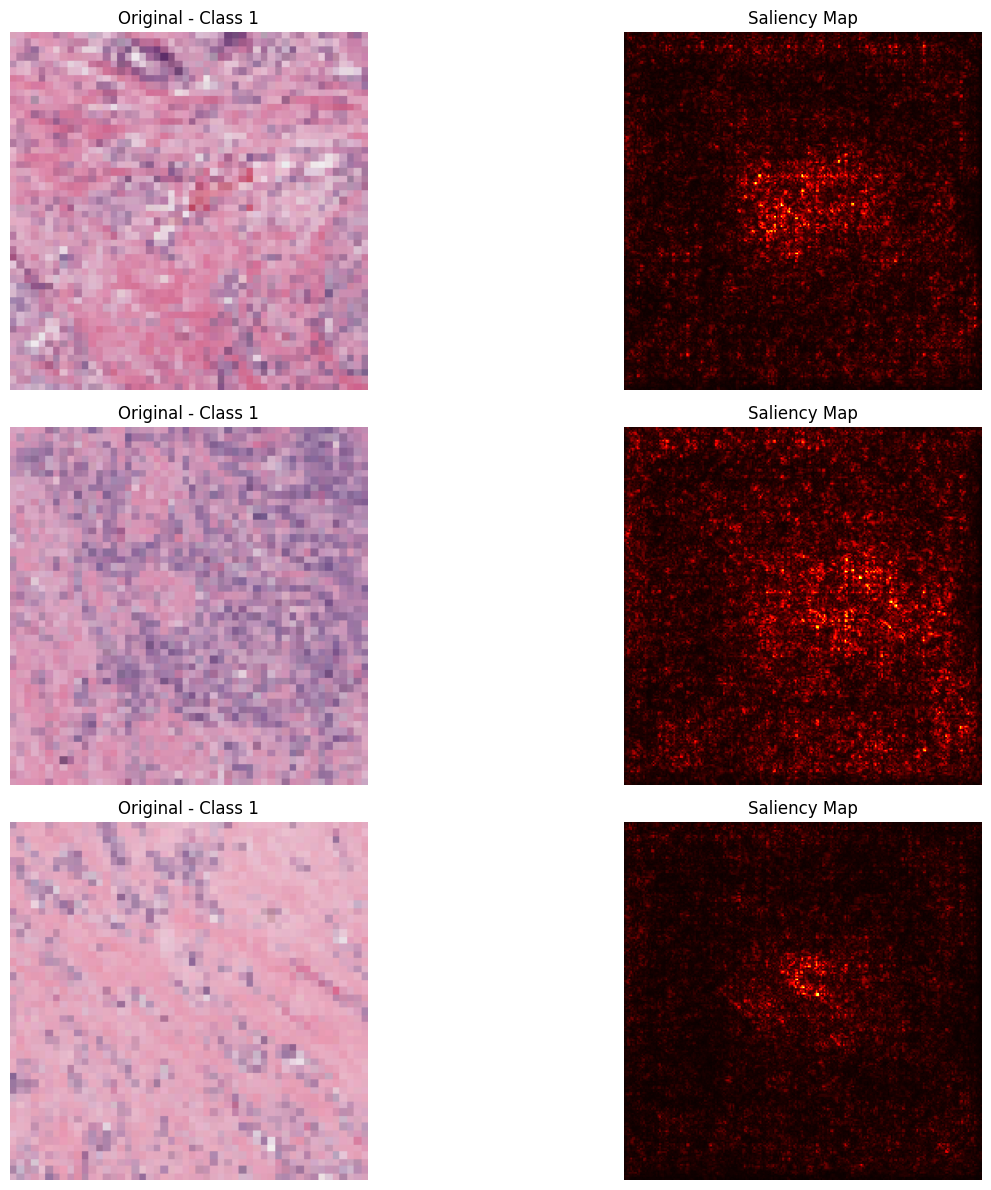

In [28]:
# 🔵 Visualize saliency for No Cancer (label=0)
visualize_multiple_saliency_maps(resnet_model_for_gradcam, class_label=0, count=3)

# 🔴 Visualize saliency for Cancer (label=1)
visualize_multiple_saliency_maps(resnet_model_for_gradcam, class_label=1, count=3)


## 🔍 Grad-CAM Insights
Grad-CAM visualizations show that the model consistently focuses on dense, stained regions when predicting cancerous patches, and mostly ignores sparse stromal tissue for non-cancerous predictions.

This aligns with known histopathological patterns, adding confidence to the model's decisions.
